In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import yfinance as yf
import pandas as pd

device = "cuda:0" if torch.cuda.is_available() else "cpu"
print(device)

bitcoin = yf.download("BTC-USD",start="2010-05-10",end="2025-07-23")['Close']
bitcoin = bitcoin.shift(1)
bitcoin.dropna(inplace=True)
bitcoin = bitcoin.reset_index()


cuda:0
YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


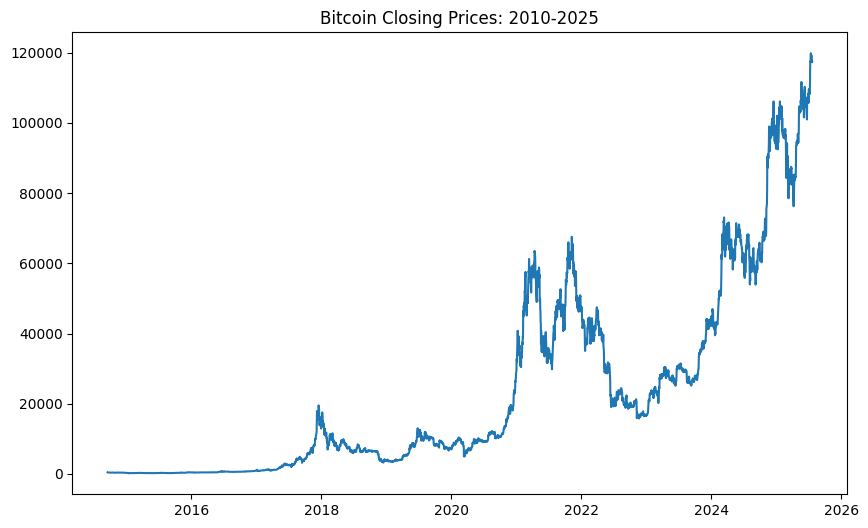

In [2]:
plt.figure(figsize=(10,6))
plt.plot(bitcoin['Date'],bitcoin['BTC-USD'])
plt.title("Bitcoin Closing Prices: 2010-2025")
plt.savefig("images/closing_prices.png")
plt.show()

In [3]:

training = bitcoin.iloc[:,1:2].values

train_size = int(len(training)* 0.80)

train_data = training[:train_size]
test_data = training[train_size:]
print(len(train_data))
print(len(test_data))

3168
793


In [4]:
scaler = MinMaxScaler()

train_data = scaler.fit_transform(train_data)
test_data = scaler.transform(test_data)


def slider(dataframe,seq_length):
    X,y = [],[]
    for i in range(len(dataframe) - seq_length - 1):
        X_ = dataframe[i:(seq_length + i)]
        y_ = dataframe[(seq_length + i)]
        X.append(X_)
        y.append(y_)
    return np.array(X),np.array(y)

seq_length = 1
X_train,y_train = slider(train_data,seq_length)
X_test,y_test = slider(test_data,seq_length)

X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).float()

X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).float()



In [5]:


class GRU(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(GRU, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.output_size = output_size
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, X):
        h0 = torch.zeros(1, X.size(0), self.hidden_size)
        out, _ = self.gru(X, h0)
        out = self.fc(out[:,-1,:])
        return out



input_size = 1
hidden_size = 64
num_layers = 2
num_layers = 1
output_size = 1


model = GRU(input_size,hidden_size,num_layers,output_size=1)
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)
loss_fn = nn.MSELoss()
epochs = 500

for epoch in range(epochs):
    y_pred = model(X_train)
    loss = loss_fn(y_pred.float(),y_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if epoch % 1 != 0:
        continue
    model.eval()
    with torch.no_grad():
        y_pred = model(X_train)
        train_rsme = np.sqrt(loss_fn(y_pred,y_train))
        y_pred_test =  model(X_test)
        test_rsme = np.sqrt(loss_fn(y_pred_test,y_test))
        print(f'Epoch: {epoch}; train_RSEM: {train_rsme:.4}; Test RSME: {test_rsme:.4}')

C:\Users\katsa\AppData\Local\Temp\ipykernel_19132\1743036886.py:42: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  train_rsme = np.sqrt(loss_fn(y_pred,y_train))
C:\Users\katsa\AppData\Local\Temp\ipykernel_19132\1743036886.py:44: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  test_rsme = np.sqrt(loss_fn(y_pred_test,y_test))


Epoch: 0; train_RSEM: 0.2599; Test RSME: 0.9403
Epoch: 1; train_RSEM: 0.2564; Test RSME: 0.9316
Epoch: 2; train_RSEM: 0.253; Test RSME: 0.9228
Epoch: 3; train_RSEM: 0.2497; Test RSME: 0.914
Epoch: 4; train_RSEM: 0.2466; Test RSME: 0.9052
Epoch: 5; train_RSEM: 0.2435; Test RSME: 0.8964
Epoch: 6; train_RSEM: 0.2406; Test RSME: 0.8876
Epoch: 7; train_RSEM: 0.2379; Test RSME: 0.8788
Epoch: 8; train_RSEM: 0.2352; Test RSME: 0.87
Epoch: 9; train_RSEM: 0.2328; Test RSME: 0.8612
Epoch: 10; train_RSEM: 0.2304; Test RSME: 0.8525
Epoch: 11; train_RSEM: 0.2282; Test RSME: 0.8438
Epoch: 12; train_RSEM: 0.2262; Test RSME: 0.8352
Epoch: 13; train_RSEM: 0.2243; Test RSME: 0.8267
Epoch: 14; train_RSEM: 0.2226; Test RSME: 0.8183
Epoch: 15; train_RSEM: 0.221; Test RSME: 0.81
Epoch: 16; train_RSEM: 0.2195; Test RSME: 0.8018
Epoch: 17; train_RSEM: 0.2182; Test RSME: 0.7938
Epoch: 18; train_RSEM: 0.2169; Test RSME: 0.786
Epoch: 19; train_RSEM: 0.2158; Test RSME: 0.7784
Epoch: 20; train_RSEM: 0.2148; Test RS

In [6]:

with torch.no_grad():
    pred = model(X_test)
    pred_np = pred.cpu().numpy()
    y_test_np = y_test.cpu().numpy()
    pred_rescaled = scaler.inverse_transform(pred_np)
    actual_rescaled = scaler.inverse_transform(y_test_np)



test_dates = bitcoin.iloc[train_size + seq_length: -1]['Date'].reset_index(drop=True)

comparison_df = pd.DataFrame({
    "Date": test_dates,
    "Actual Price": actual_rescaled.flatten(),
    "Predicted Price": pred_rescaled.flatten()
})

print(comparison_df.head(20))
print(comparison_df.tail(20))


         Date  Actual Price  Predicted Price
0  2023-05-23  26851.277344     26541.982422
1  2023-05-24  27225.726562     26639.732422
2  2023-05-25  26334.818359     27015.433594
3  2023-05-26  26476.208984     26121.798828
4  2023-05-27  26719.291016     26263.562500
5  2023-05-28  26868.355469     26507.343750
6  2023-05-29  28085.648438     26656.865234
7  2023-05-30  27745.884766     27878.798828
8  2023-05-31  27702.349609     27537.578125
9  2023-06-01  27219.660156     27493.869141
10 2023-06-02  26819.974609     27009.343750
11 2023-06-03  27249.589844     26608.330078
12 2023-06-04  27075.128906     27039.380859
13 2023-06-05  27119.068359     26864.314453
14 2023-06-06  25760.097656     26908.400391
15 2023-06-07  27238.783203     25545.781250
16 2023-06-08  26346.000000     27028.535156
17 2023-06-09  26508.216797     26133.007812
18 2023-06-10  26480.375000     26295.660156
19 2023-06-11  25851.240234     26267.740234
          Date   Actual Price  Predicted Price
771 2025

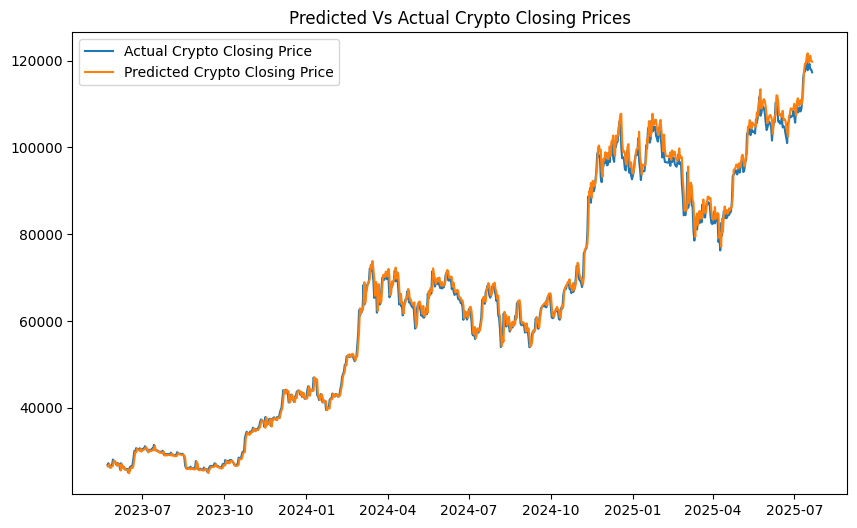

In [8]:
plt.figure(figsize=(10,6))
plt.plot(comparison_df['Date'],comparison_df['Actual Price'],label="Actual Crypto Closing Price")
plt.plot(comparison_df['Date'],comparison_df['Predicted Price'],label="Predicted Crypto Closing Price")
plt.title("Predicted Vs Actual Crypto Closing Prices")
plt.savefig("images/predicted_vs_actual_closing_prices_gru.png")
plt.legend()
plt.show()





